In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

comment = "Synthetic core with tapered ensemble as prior"
nb_name = "nb_case_core_synthetic"

In [2]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = False)
core.generate_map()

core.condtab(normsize=10000, quantiles = 1000, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble") #model_hist = "ensemble"
#core.semivar(model_lags = 20, model = "exponential", max_dist = 20000, lag_length = 100,
#             zero_nugget = True, hit_target_var = False)

# Covariance model

All eigenvalues > 0: True
Cov model is pos def: True


<IPython.core.display.Javascript object>


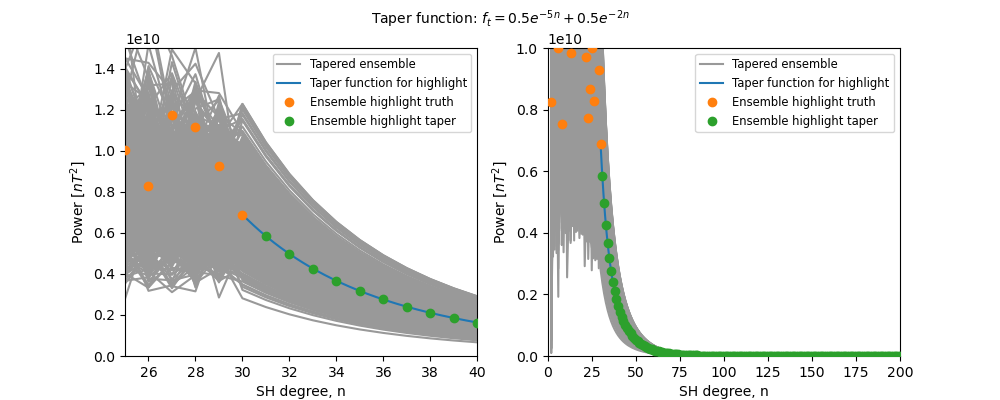

In [3]:
core.cov_model_taper(r_at = core.r_cmb, tap_to = 500, tap_exp_p1 = 5, tap_exp_p2 = 2,
                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True,
                     save_fig = True, save_string = "case_core_synthetic", save_dpi = 300)

# Synthetic sat

In [4]:
C_e_const = 2.0

s_sat = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)

s_sat.generate_map(grid_type = "swarm")

s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

# Source truth

In [5]:
s_source = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_source.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.r_cmb, grid_in, calc_sph_d = False)

s_source.generate_map()

# System equations

In [6]:
core.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = core.C_ens_tap)

# SDSSIM

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 18.332 minutes 
Total elapsed time: 18.332 minutes 
Variance: 320395243716.742
Mean: -7730.704
Max: 2025272.990
Min: -1421312.812
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 18.657 minutes 
Total elapsed time: 36.989 minutes 
Variance: 329494497093.317
Mean: -9142.046
Max: 2107863.684
Min: -1718118.948
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 18.053 minutes 
Total elapsed time: 55.042 minutes 
Variance: 316231347003.761
Mean: -7035.604
Max: 1936571.144
Min: -1886269.757
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 18.578 minutes 
Total elapsed time: 1.227 hours 
Variance: 332798499119.221
Mean: -13178.265
Max: 4836756.463
Min: -1992455.096
Run nr.: 4


Seqsim RMSE:	 [[1.97031106 1.

<IPython.core.display.Javascript object>


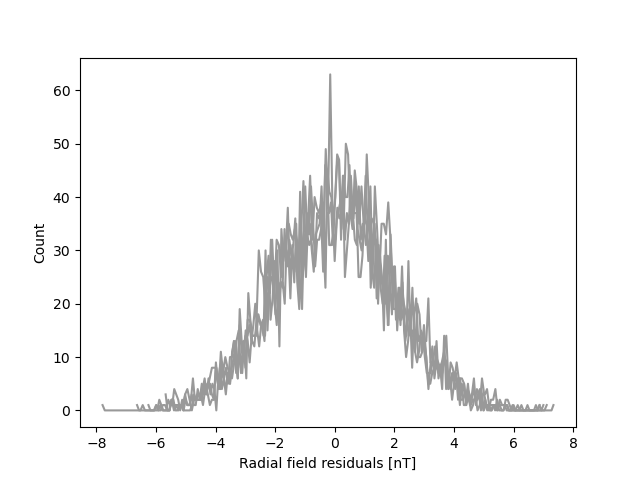

In [7]:
N_sim = 4
core.target_var = np.max(core.C_ens_tap)

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        s_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

In [8]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shc_grid)

In [9]:
#core.covmod_lsq_equiv(s_sat.data, C_Br_model, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


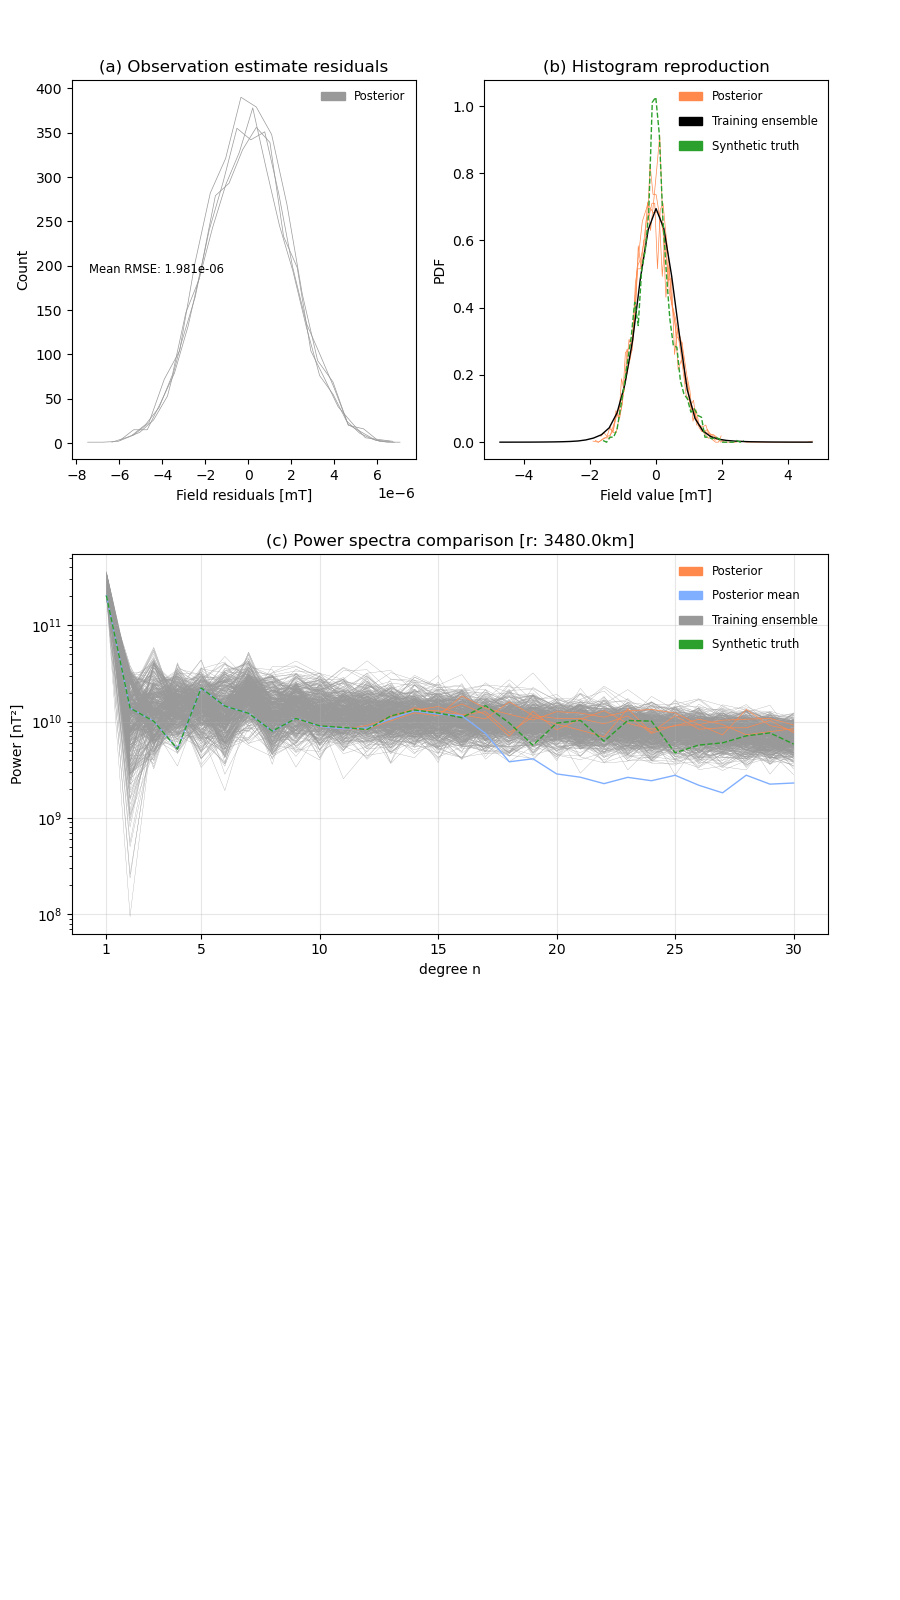

In [10]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

#truth_obj = s_source

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = None, truth_obj = s_source,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              spec_ti_ens = True, spec_lwidth = .5, label_fontsize = "small",
                              res_use = True, sv_use = False, unit_field = "[mT]",
                              unit_transform_n_to_m = True, patch_legend = True,
                              model_dict = {}, figsize=(9,16), hist_ti_ens = True, hist_density = True,
                              hist_bins = 41, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "case_core_synthetic", save_dpi = 300)

In [ ]:
core.pickle_save_self(nb_name)

In [24]:
list_coord = np.array([[0,2], [-30,30], [45,-45], [70,-170]])
list_coord[:,0] = 90 - list_coord[:,0]
list_coord[:,1][list_coord[:,1]<0.0] = 360 + list_coord[:,1][list_coord[:,1]<0.0]

m_coord_sph = np.hstack((90 - core.lat.reshape(-1,1), core.lon.reshape(-1,1)))

idx_min = []
for coord in list_coord:
    idx_min.append(np.sum(np.abs(m_coord_sph - coord),axis=1).argmin())
    
print(idx_min)

m_hists_coord = m_coord_sph[idx_min]

m_hists = core.m_DSS[idx_min,:]

[915, 1225, 480, 215]


In [25]:
left=0.08
bottom=0.12
right=0.92
top=0.95
wspace = 0.2
hspace=0.25

color_rgb_zesty_pos = (1.0,  0.5372549019607843,  0.30196078431372547)
color_rgb_zesty_neg = (0.5019607843137255,  0.6862745098039216,  1.0)

<IPython.core.display.Javascript object>


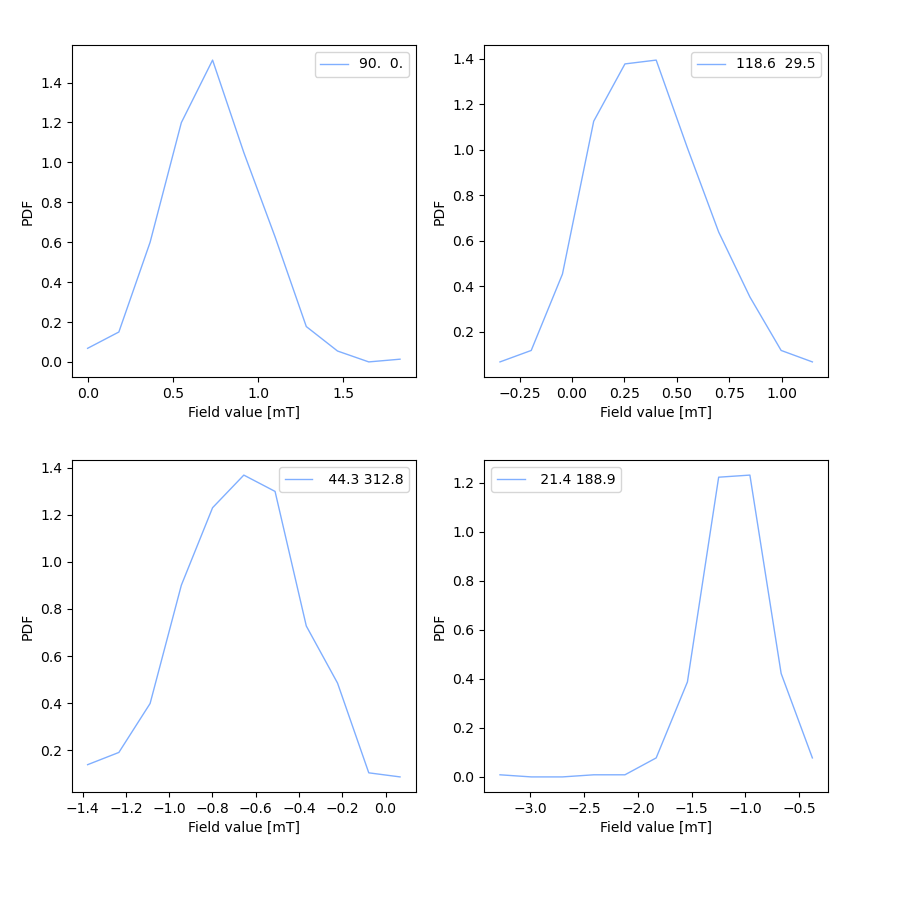

In [29]:
m_hists_scale = m_hists*10**(-6)

tile_size_row = 2
tile_size_column = 2

label_fontsize = 10

fig = plt.figure(figsize=(9,9)) # Initiate figure with constrained layout
# Generate ratio lists
h_ratio = [1]*tile_size_row
w_ratio = [1]*tile_size_column
gs = fig.add_gridspec(tile_size_row, tile_size_column, height_ratios=h_ratio, width_ratios=w_ratio) # Add x-by-y grid

for i in np.arange(0,list_coord.shape[0]):

    ax = fig.add_subplot(gs[i])
    
    y,binEdges=np.histogram(m_hists_scale[i,:],bins=11,density=True)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])    
    ax.plot(bincenters, y, '-', color = color_rgb_zesty_neg, 
            label='{}'.format(str(np.round(m_hists_coord[i,:],decimals=1))).lstrip('[').rstrip(']'),
            linewidth = 1)

    #ax.set_title('test')
    #ax.annotate("test", (0.05, 0.5), xycoords='axes fraction', va='center', fontsize = label_fontsize)
    ax.set_xlabel("Field value [mT]")
    ax.set_ylabel("PDF")
    ax.legend(loc='best', fontsize = label_fontsize)
    

fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

In [16]:
#core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)
core.grid_glq(nmax = 400, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


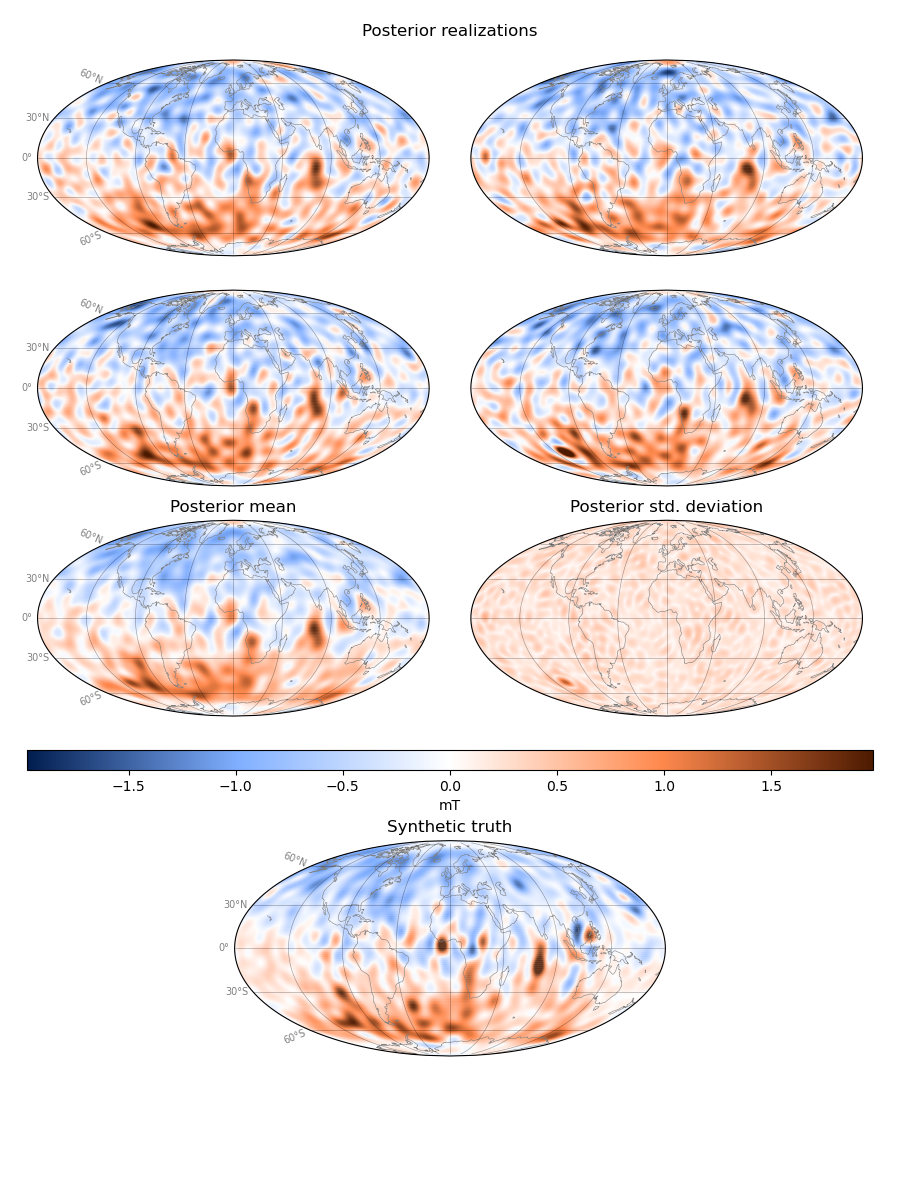

In [18]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.01, cbar_mm_factor = 2/3,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "case_core_synthetic", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)
